In [1]:
import sys
sys.path.insert(0, '../src')
from TheCov import ThePowerCov

from tqdm.notebook import tqdm

from nbodykit.source.catalog import CSVCatalog
from nbodykit.lab import cosmology, transform

import numpy as np

import matplotlib
from matplotlib import pyplot as plot
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rc('font', size=14, family='STIXGeneral')
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize'] = 14
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.facecolor']= 'white'

color_a = '#333'
color_b = '#e13'
color_c = '#1e3'

cmap = LinearSegmentedColormap.from_list("cmap_name", ['#04f', '#fff', '#f30'])

In [2]:
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

# Let's use a 10x random catalog to make things faster for now

# From: https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.tar.gz
# Columns described in: http://skiesanduniverses.org/Products/MockCatalogues/SDSS/BOSSLRGDR12MDP/
randoms = CSVCatalog('data/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.dat',
                     names=['RA', 'DEC', 'Z', 'NZ', 'BIAS', 'VETO FLAG', 'Weight'],
                     delim_whitespace=True)

randoms = randoms[randoms['VETO FLAG'] > 0]
randoms = randoms[(randoms['Z'] > 0.5) * (randoms['Z'] < 0.75)]

randoms['WEIGHT_FKP'] = 1./(1. + 1e4*randoms['NZ'])

randoms['Position'] = transform.SkyToCartesian(
    randoms['RA'], randoms['DEC'], randoms['Z'], degrees=True, cosmo=cosmo)

cov = ThePowerCov.GaussianSurveyWindowCovariance()
cov.set_randoms(randoms, 48, 3750, 1/10)
cov.compute_cartesian_ffts(tqdm=tqdm)
cov.save_cartesian_ffts('data/cartesian_ffts.npz')

Computing moments of W12
Computing 0th order moment... Done!
Computing 2nd order moments


  0%|          | 0/6.0 [00:00<?, ?it/s]

Computing 4th order moments


  0%|          | 0/15.0 [00:00<?, ?it/s]

Computing moments of W22
Computing 0th order moment... Done!
Computing 2nd order moments


  0%|          | 0/6.0 [00:00<?, ?it/s]

Computing 4th order moments


  0%|          | 0/15.0 [00:00<?, ?it/s]

In [2]:
cov = ThePowerCov.GaussianSurveyWindowCovariance()
cov.load_cartesian_ffts('data/cartesian_ffts.npz')
cov.set_kbins(0., 0.25, 0.005)
cov.compute_window_kernels(kmodes_sampled=250, icut=15, tqdm=tqdm, nthreads=8)
cov.save_window_kernels('data/winkernels.npz')

Sorting k-modes in shells:   0%|          | 0/50 [00:00<?, ?it/s]

Computing window kernels:   0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
cov = ThePowerCov.GaussianSurveyWindowCovariance()

cov.load_cartesian_ffts('data/cartesian_ffts.npz')
cov.load_window_kernels('data/winkernels.npz')

pk_data = np.array([np.loadtxt(f'data/pre_recon_patchy_NGC_z3/ps1D_patchyDR12_ngc_combined_bianchi_z3_{i}_COMPnbar_TIC_340_650_360_120.dat',
                               skiprows=30, unpack=True, max_rows=50) for i in range(1,2049)])

k, _, P0, P2, P4, _, _ = np.average(pk_data, axis=0)

# k  = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/k_Patchy.dat')
# P0 = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/P0_fit_Patchy.dat')
# P2 = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/P0_fit_Patchy.dat')
# P4 = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/P0_fit_Patchy.dat')

cov.load_multipole(k, P0, 0)
cov.load_multipole(k, P2, 2)
cov.load_multipole(k, P4, 4)

cov.set_kbins(0., 0.25, 0.005)

cov.compute_covariance()

In [4]:
cov.I['12']

array(56498.98474133)

In [5]:
cov.W['22'][cov.W['22'].shape[0]//2-1,
            cov.W['22'].shape[1]//2-1,
            cov.W['22'].shape[2]//2-1,]

(9.085358+0j)

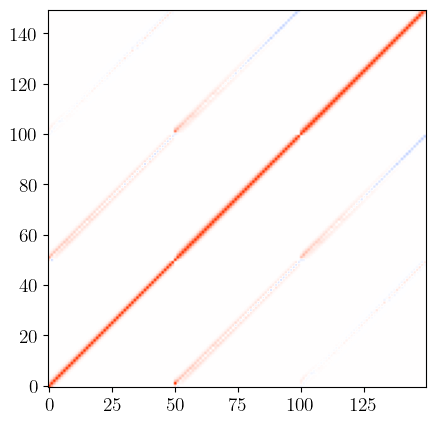

In [6]:
plot.figure(figsize=(5,5), dpi=100)
plot.imshow(cov.correlation, origin='lower', vmin=-1, vmax=1, cmap=cmap)

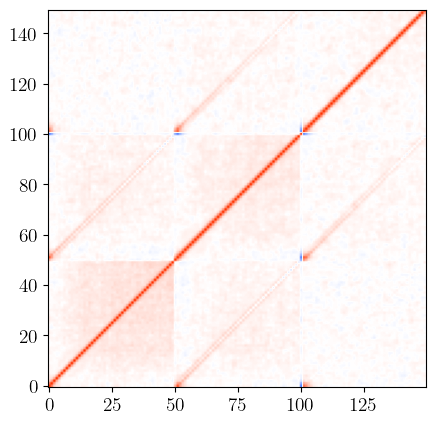

In [7]:
# mockcov = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/Patchy_CovarianceMatrix.dat')
mockcov = np.cov([np.concatenate([P0,P2,P4]) for _,_,P0,P2,P4,_,_ in pk_data], rowvar=False)
mockcor = cov.cov2corr(mockcov)

plot.figure(figsize=(5,5), dpi=100)
plot.imshow(mockcor, origin='lower', vmin=-1, vmax=1, cmap=cmap)

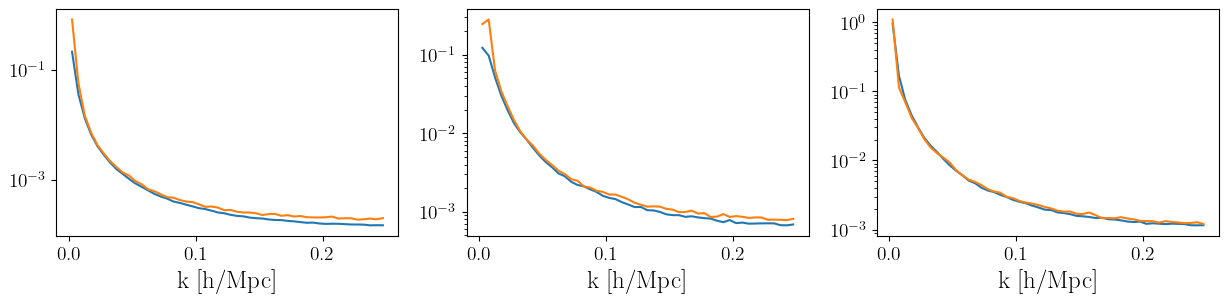

In [8]:
k = cov._k

p2 = cov._P[0](k)**2

fig, axes = plot.subplots(1, 3, figsize=(15,3))
for l, ax in enumerate(axes):
    l1, l2 = l*len(k), (l+1)*len(k)

    a = np.diag(cov.covariance)[l1:l2]/p2
    b = np.diag(mockcov)[l1:l2]/p2
    ax.semilogy(k,a)
    ax.semilogy(k,b)
    ax.set_xlabel('k [h/Mpc]')